Forecasting Multiple target columns at once using Sktime's Library
* After prior evaluations & testing I will be using XGBoost for Modelling & Forecasting.


Imports

In [169]:
import pandas as pd 
from sklearn import *
from sktime import *

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sktime.forecasting.compose import DirectTimeSeriesRegressionForecaster
from sktime.forecasting.compose import RecursiveTabularRegressionForecaster
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations import *

from sktime.performance_metrics.forecasting import mean_absolute_error

from xgboost import XGBRegressor

import matplotlib.pyplot as plt 
import numpy as np 

from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as tsa
import statsmodels.formula.api as smf
import statsmodels.api as sm




Load in Data
* Download 'createdDataFinal.csv' from datasets folder on 'Forecasting' Repo to replicate script.
* Combines a number of time series datasets into one csv for forecasting of multiple target columns at once.
* Data has been rescaled on a Daily frequency.

In [170]:
#Load in data
df = pd.read_csv('createdDataFinal.csv',index_col='Date', parse_dates=True)
#View Head
df.head()

C:\Users\pgrady\AppData\Local\Temp\ipykernel_17952\1842538066.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv('createdDataFinal.csv',index_col='Date', parse_dates=True)


,Temp,ED Attends,Pollution,Passengers,Births,Electric Production,Drug Sales,Beer Production
Date,,,,,,,,
1981-01-01,20.7,164,129,112,35,72.5052,3.526591,93.2
1981-02-01,17.9,269,148,118,32,70.6720,3.180891,96.0
1981-03-01,18.8,209,159,132,30,62.4502,3.252221,95.2
1981-04-01,14.6,205,181,129,31,57.4714,3.611003,77.1
1981-05-01,15.8,193,138,121,44,55.3151,3.565869,70.9


In [171]:
df.tail()

,Temp,ED Attends,Pollution,Passengers,Births,Electric Production,Drug Sales,Beer Production
Date,,,,,,,,
1981-05-20,2.1,84,67,606,36,86.5562,9.800215,116.0
1981-05-21,3.4,79,106,508,55,79.1919,10.816994,113.9
1981-05-22,5.4,84,159,461,41,74.6891,10.654223,127.5
1981-05-23,9.6,87,198,390,45,81.0740,12.512323,131.4
1981-05-24,11.5,108,190,432,41,90.4855,12.161210,145.9


Exploratory Data Analysis
* Check shape of DataFrame 
* Check data types
* Get data statistics 
* Check missing values
* Visualise data



In [172]:
#Check shape of data
print(df.shape)
# 144 Rows / 8 Columns 

# Check data types
print(df.info())

(144, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1981-01-01 to 1981-05-24
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temp                 144 non-null    float64
 1   ED Attends           144 non-null    int64  
 2   Pollution            144 non-null    int64  
 3   Passengers           144 non-null    int64  
 4   Births               144 non-null    int64  
 5   Electric Production  144 non-null    float64
 6   Drug Sales           144 non-null    float64
 7   Beer Production      144 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 10.1 KB
None


In [173]:
# Get Data Statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp,144.0,14.197222,4.454603,2.10000,11.150000,14.55000,16.900000,25.00000
ED Attends,144.0,133.888889,45.619912,34.00000,91.750000,142.00000,167.250000,269.00000
Pollution,144.0,70.666667,46.977007,20.00000,29.000000,55.00000,96.500000,198.00000
Passengers,144.0,280.298611,119.966317,104.00000,180.000000,265.50000,360.500000,622.00000
Births,144.0,39.645833,7.273353,23.00000,34.000000,39.00000,45.000000,58.00000
Electric Production,144.0,73.262574,9.086771,55.31510,67.253175,73.32900,79.205325,98.97320
Drug Sales,144.0,7.593111,3.178084,2.81452,5.092465,6.93973,9.940282,16.82835
Beer Production,144.0,97.410417,17.256501,64.80000,84.875000,96.00000,107.450000,145.90000


In [174]:
# Check missing values of the dataset
df.isnull().sum()

Temp                   0
ED Attends             0
Pollution              0
Passengers             0
Births                 0
Electric Production    0
Drug Sales             0
Beer Production        0
dtype: int64

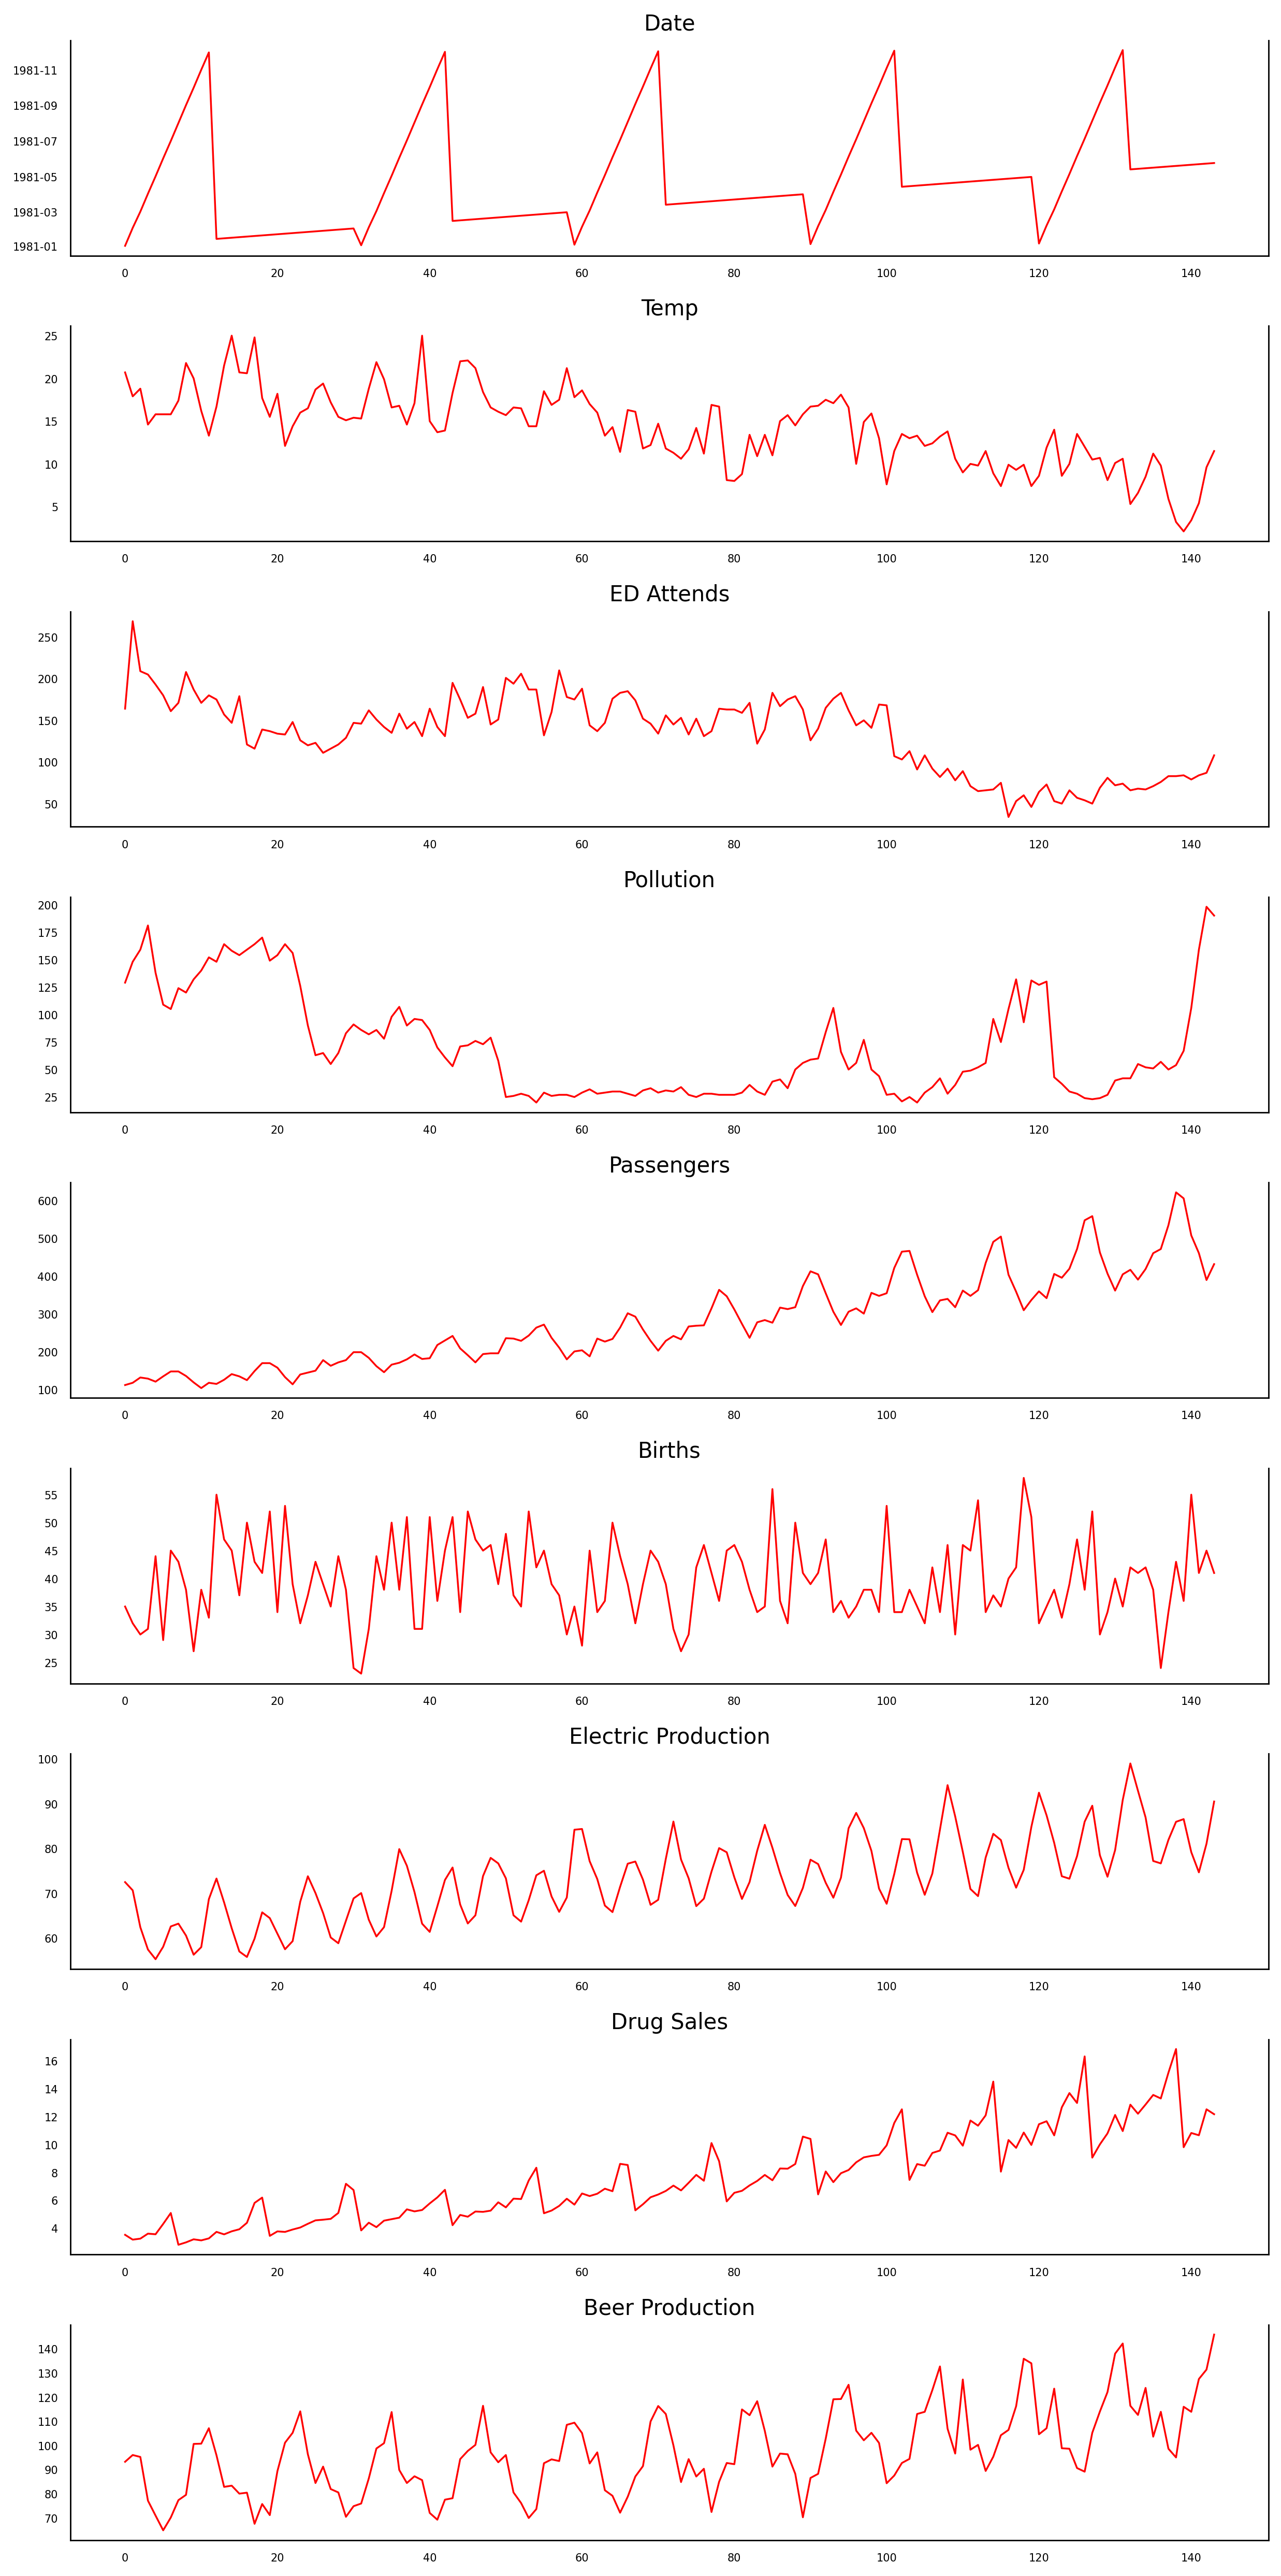

In [175]:
# Visualise Data
#Reset Index
df = df.reset_index()
# Plot All Specialties that are Urgent
fig, axes = plt.subplots(nrows=9, ncols=1, dpi=250, figsize=(10,20))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [176]:
#Set Date col back to index
df = df.set_index('Date')

Check Stationarity 
* ADF Test
* Logging 
* Visualise log process

In [177]:
# ADF Test
# Get P-Value for all specialties in Routine
p_value_results = {}

for col in df.columns.values:  #or edit this for a subset of columns first
    p_value_results[col] = tsa.adfuller(df[col])[1]

p_value_results

{'Temp': 0.049226781020672676,
 'ED Attends': 0.5934107496520763,
 'Pollution': 0.24029508628004465,
 'Passengers': 0.991880243437641,
 'Births': 2.4187192354474617e-20,
 'Electric Production': 0.9065490308970531,
 'Drug Sales': 0.9979233477139685,
 'Beer Production': 0.9987998384172254}

out_array :           Temp  ED Attends  Pollution  Passengers    Births  \
0    3.077312    5.105945   4.867534    4.727388  3.583519   
1    2.939162    5.598422   5.003946    4.779123  3.496508   
2    2.985682    5.347108   5.075174    4.890349  3.433987   
3    2.747271    5.327876   5.204007    4.867534  3.465736   
4    2.821379    5.267858   4.934474    4.804021  3.806662   
..        ...         ...        ...         ...       ...   
139  1.131402    4.442651   4.219508    6.408529  3.610918   
140  1.481605    4.382027   4.672829    6.232448  4.025352   
141  1.856298    4.442651   5.075174    6.135565  3.737670   
142  2.360854    4.477337   5.293305    5.968708  3.828641   
143  2.525729    4.691348   5.252273    6.070738  3.737670   

     Electric Production  Drug Sales  Beer Production  
0               4.297356    1.509969         4.545420  
1               4.272100    1.430524         4.574711  
2               4.150255    1.447441         4.566429  
3               4.

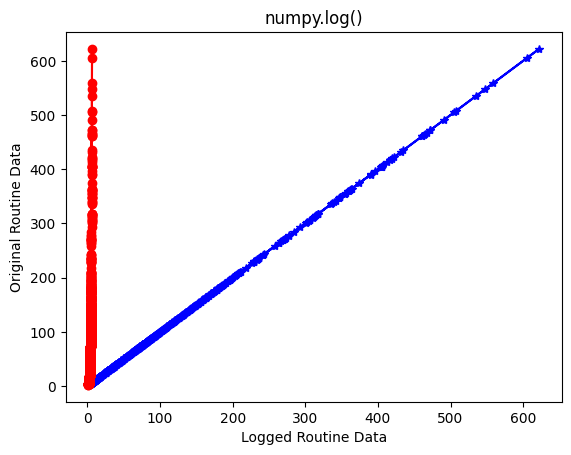

In [178]:
#Log data to make stationary

# Showing Graphical representation of log1p() function
import numpy as np
import matplotlib.pyplot as plt
df = df.reset_index()
in_array = df.drop(columns=['Date']) 
loggedDf = np.log1p(in_array)
  
print ("out_array : ", loggedDf)
  
plt.plot(in_array, in_array, 
         color = 'blue', marker = "*")
  
# red for numpy.log()
plt.plot(loggedDf, in_array, 
         color = 'red', marker = "o")
           
plt.title("numpy.log()")
plt.xlabel("Logged Routine Data")
plt.ylabel("Original Routine Data")
plt.show() 

In [179]:
#Add 'Date' col back to logged data
date_column = df['Date']
loggedDf = pd.concat([date_column, loggedDf], axis = 1)

#Set Date col as index
loggedDf = loggedDf.set_index('Date')

#Rename df
df = loggedDf

#View head
df.head()

,Temp,ED Attends,Pollution,Passengers,Births,Electric Production,Drug Sales,Beer Production
Date,,,,,,,,
1981-01-01,3.077312,5.105945,4.867534,4.727388,3.583519,4.297356,1.509969,4.545420
1981-02-01,2.939162,5.598422,5.003946,4.779123,3.496508,4.272100,1.430524,4.574711
1981-03-01,2.985682,5.347108,5.075174,4.890349,3.433987,4.150255,1.447441,4.566429
1981-04-01,2.747271,5.327876,5.204007,4.867534,3.465736,4.068538,1.528445,4.357990
1981-05-01,2.821379,5.267858,4.934474,4.804021,3.806662,4.030963,1.518609,4.275276


Train Test Split
* Test on last 28 days of data

In [180]:
#Train Test Split using Sktime's Temporal_train_test_split()
# Test Size 28 days - Forecasting 28 days into future
train, test = temporal_train_test_split(df, test_size=28)
print(train.shape)
print(test.shape)

(116, 8)
(28, 8)


Define Forecasting Horizon
* Set forecast horizon to 28 days

In [181]:
#Set forecasting horizon - 28 days
fh = np.arange(1,29)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In-Sample Forecasts

- Making an in-sample forecast for every numeric target column to get the actual and predicted values from the last 28 days of the data set

* Loop through columns and get an in-sample forecast for the last 28 days 
* Using XGBoost
* Adds in-sample predictions to in_sample_forecasts df
* Loop to get actual Vs predicted values for last 28 days of each column


In [182]:

#Create a loop to make an in-sample forecast for last 28 days using xgboost
in_sample_forecasts = pd.DataFrame()
for i in range(1,9):
    y_train = train[df.columns[i-1]]
    y_train=y_train.reset_index(drop=True)
    regressor = XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=0)
    forecaster = make_reduction(regressor, window_length=28)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    in_sample_forecasts[df.columns[i-1]] = y_pred

    #Create a df with actual vs predicted for in sample 
    actual_vs_pred = pd.DataFrame({'actual': test[df.columns[i-1]].values, 'predicted': y_pred})
    actual_vs_pred.index = test.index[-28:]
    print(df.columns[i-1],'actual vs predicted:')
    print(actual_vs_pred)

    actual_vs_pred.to_csv('actualVSpred.csv')

Temp actual vs predicted:
              actual  predicted
Date                           
1981-04-27  2.388763   2.164338
1981-04-28  2.332144   2.489282
1981-04-29  2.388763   2.565998
1981-04-30  2.128232   2.581638
1981-01-05  2.261763   2.400206
1981-02-05  2.557227   2.698805
1981-03-05  2.708050   2.737575
1981-04-05  2.261763   2.787798
1981-05-05  2.397895   2.450353
1981-06-05  2.674149   2.276677
1981-07-05  2.564949   2.336709
1981-08-05  2.442347   2.326166
1981-09-05  2.459589   2.237916
1981-10-05  2.208274   2.278989
1981-11-05  2.406945   2.215076
1981-12-05  2.451005   2.149000
1981-05-13  1.840550   2.268307
1981-05-14  2.028148   2.606077
1981-05-15  2.251292   2.442655
1981-05-16  2.501436   2.264807
1981-05-17  2.379546   2.333284
1981-05-18  1.931521   2.600541
1981-05-19  1.435085   2.670205
1981-05-20  1.131402   2.326712
1981-05-21  1.481605   2.163409
1981-05-22  1.856298   2.248954
1981-05-23  2.360854   2.270859
1981-05-24  2.525729   2.145069
ED Attends act

Inverse Logging using np.expm1

In [183]:
#Inverse in-sample logged forecast
in_sample_forecasts = np.expm1(in_sample_forecasts)

Add Date column to in_sample_forecasts df

In [184]:
from datetime import timedelta
#Add date col to in_sample df
in_sample_forecasts['Date'] = pd.date_range(start=df.index[len(train)], periods=28, freq='D')
in_sample_forecasts

,Temp,ED Attends,Pollution,Passengers,Births,Electric Production,Drug Sales,Beer Production,Date
116,7.708832,68.304719,68.520454,504.275033,47.619775,78.880311,9.564825,115.512544,1981-04-27
117,11.052621,74.197139,64.438911,403.970112,37.645226,73.150304,9.318256,123.138547,1981-04-28
118,12.013634,63.954373,64.745298,349.838935,42.820219,78.400795,11.825471,129.918207,1981-04-29
119,12.218768,63.368305,68.406148,357.523856,39.933425,82.566520,10.883882,126.780037,1981-04-30
120,10.025443,66.824515,67.351841,357.126258,36.752107,92.798481,11.842000,110.100098,1981-05-01
121,13.861959,68.885395,72.094965,357.126258,37.008289,91.271512,11.451876,102.438382,1981-05-02
122,14.449475,69.273895,74.180467,372.525052,37.402811,82.733010,11.646539,121.741033,1981-05-03
123,15.245211,69.450677,74.614014,395.439688,40.684098,72.489988,11.906815,104.200851,1981-05-04
124,10.592437,64.611790,60.068907,385.318323,45.175129,71.820238,11.889348,102.587100,1981-05-05
125,8.744250,68.726188,43.476172,453.183015,34.377889,76.290414,12.306765,98.262071,1981-05-06


Change Date col position to index 0

In [185]:
#Change position of Date col to index position 0

# Pop date col off to move to first position
column_to_move = in_sample_forecasts.pop('Date')
# insert column with insert(location, column_name, column_value)
in_sample_forecasts.insert(0, 'Date', column_to_move)
in_sample_forecasts

,Date,Temp,ED Attends,Pollution,Passengers,Births,Electric Production,Drug Sales,Beer Production
116,1981-04-27,7.708832,68.304719,68.520454,504.275033,47.619775,78.880311,9.564825,115.512544
117,1981-04-28,11.052621,74.197139,64.438911,403.970112,37.645226,73.150304,9.318256,123.138547
118,1981-04-29,12.013634,63.954373,64.745298,349.838935,42.820219,78.400795,11.825471,129.918207
119,1981-04-30,12.218768,63.368305,68.406148,357.523856,39.933425,82.566520,10.883882,126.780037
120,1981-05-01,10.025443,66.824515,67.351841,357.126258,36.752107,92.798481,11.842000,110.100098
121,1981-05-02,13.861959,68.885395,72.094965,357.126258,37.008289,91.271512,11.451876,102.438382
122,1981-05-03,14.449475,69.273895,74.180467,372.525052,37.402811,82.733010,11.646539,121.741033
123,1981-05-04,15.245211,69.450677,74.614014,395.439688,40.684098,72.489988,11.906815,104.200851
124,1981-05-05,10.592437,64.611790,60.068907,385.318323,45.175129,71.820238,11.889348,102.587100
125,1981-05-06,8.744250,68.726188,43.476172,453.183015,34.377889,76.290414,12.306765,98.262071


Out-of-Sample Forecasts

- Get Predictions for every numeric column for the next 28 days beyond the end of the dataset
- Use same process as in_sample forecasts
- Forecast should start from - 25-05-1981


In [186]:
#Create a loop to make an in-sample forecast for last 28 days using xgboost
future_forecasts = pd.DataFrame()
for i in range(1,9):
    y = test[df.columns[i-1]]
    y = y.reset_index(drop=True)
    future_regressor = XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=0)
    future_forecaster = make_reduction(future_regressor)
    future_forecaster.fit(y)
    y_pred_future = future_forecaster.predict(fh)
    future_forecasts[df.columns[i-1]] = y_pred_future

future_forecasts


,Temp,ED Attends,Pollution,Passengers,Births,Electric Production,Drug Sales,Beer Production
28,1.318377,4.665355,5.253410,5.981748,3.443357,4.541450,2.605317,4.776818
29,1.046199,4.652103,5.254158,5.996064,3.563965,4.492313,2.600174,4.798264
30,1.090226,4.465410,5.253410,6.033769,3.725153,4.438332,2.629861,4.813491
31,1.153067,4.690147,5.254158,6.062067,3.601170,4.387155,2.670148,4.777696
32,1.153809,4.690147,4.926096,6.140000,3.697988,4.428815,2.659902,4.779329
33,1.911940,4.690147,4.926096,6.042934,3.693235,4.451720,2.771885,4.616184
34,1.547716,4.690147,4.926096,6.158832,3.736932,4.494745,2.653569,4.600258
35,1.230616,4.690147,4.926096,6.304042,3.772348,4.424352,2.591021,4.754469
36,1.039091,4.690147,4.926096,6.405872,3.298886,4.371824,2.465578,4.753929
37,1.112390,4.690147,4.926096,6.216391,3.565662,4.395203,2.524302,4.792816


Inverse Logging for Out-of-sample Forecasts
- Use same inverse process from in_sample

In [187]:
future_forecasts = np.expm1(future_forecasts)

Add Date col to Future forecast df

In [188]:
#Add Date column back to future forecast dataframe starting at next date from end of dataset
future_forecasts['Date'] = pd.date_range(start=df.index[143]+timedelta(days=1), periods=28, freq='D')

Change Date col position to index 0

In [189]:
#Change position of Date col to index position 0

# Pop date col off to move to first position
future_column_to_move = future_forecasts.pop('Date')
# insert column with insert(location, column_name, column_value)
future_forecasts.insert(0, 'Date', future_column_to_move)
future_forecasts

,Date,Temp,ED Attends,Pollution,Passengers,Births,Electric Production,Drug Sales,Beer Production
28,1981-05-25,2.737353,105.203303,190.217274,395.132244,30.291828,92.826708,12.535510,117.725995
29,1981-05-26,1.846811,103.805204,190.360388,400.843902,34.302907,88.327814,12.466080,120.299604
30,1981-05-27,1.974947,85.956653,190.217274,416.284870,40.477597,83.633662,12.871840,122.160806
31,1981-05-28,2.167895,107.869226,190.360388,428.261614,35.641082,79.411328,13.442108,117.830265
32,1981-05-29,2.170245,107.869226,136.840392,463.053730,39.366008,82.832048,13.294886,118.024437
33,1981-05-30,5.766204,107.869226,136.840392,420.126986,39.174599,84.774369,14.988743,100.107444
34,1981-05-31,3.700720,107.869226,136.840392,471.875468,40.969043,88.545355,13.204644,98.509973
35,1981-06-01,2.423339,107.869226,136.840392,545.777710,42.482038,82.458683,12.343386,115.101977
36,1981-06-02,1.826645,107.869226,136.840392,604.389677,26.082447,78.187922,10.770282,115.039325
37,1981-06-03,2.041618,107.869226,136.840392,499.892050,34.362853,80.061055,11.482186,119.640634


Round specific columns predictions 

In [190]:
#Round Predictions that require rounding to nearest whole number
future_forecasts[['ED Attends', 'Births', 'Passengers']] = round(future_forecasts[['ED Attends', 'Births', 'Passengers']])
future_forecasts

,Date,Temp,ED Attends,Pollution,Passengers,Births,Electric Production,Drug Sales,Beer Production
28,1981-05-25,2.737353,105.0,190.217274,395.0,30.0,92.826708,12.535510,117.725995
29,1981-05-26,1.846811,104.0,190.360388,401.0,34.0,88.327814,12.466080,120.299604
30,1981-05-27,1.974947,86.0,190.217274,416.0,40.0,83.633662,12.871840,122.160806
31,1981-05-28,2.167895,108.0,190.360388,428.0,36.0,79.411328,13.442108,117.830265
32,1981-05-29,2.170245,108.0,136.840392,463.0,39.0,82.832048,13.294886,118.024437
33,1981-05-30,5.766204,108.0,136.840392,420.0,39.0,84.774369,14.988743,100.107444
34,1981-05-31,3.700720,108.0,136.840392,472.0,41.0,88.545355,13.204644,98.509973
35,1981-06-01,2.423339,108.0,136.840392,546.0,42.0,82.458683,12.343386,115.101977
36,1981-06-02,1.826645,108.0,136.840392,604.0,26.0,78.187922,10.770282,115.039325
37,1981-06-03,2.041618,108.0,136.840392,500.0,34.0,80.061055,11.482186,119.640634
